## 1. 데이터랭글링

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

전체 그래프 기본 설정값 지정

In [44]:
plt.rcParams['figure.figsize']=(10,6)
plt.rcParams['figure.dpi']=100
plt.rcParams['font.family']='NanumGothic'

MultiIndex로 데이터 불러오기

In [45]:
crim=pd.read_csv(r'.\data\5대+범죄+발생현황_20250811160958.csv',encoding='utf-8', 
                 header=[2,3])

In [46]:
crim.head()

자치구별(1) 자치구별(2)     소계          살인        강도      강간·강제추행           절도  \
  자치구별(1) 자치구별(2)     발생     검거   발생   검거   발생   검거      발생    검거     발생   
0      합계      소계  86213  64823  150  144  129  117    5764  5395  37038   
1      합계     종로구   2981   3485    5    6    5    7     239  1138   1169   
2      합계      중구   3348   2465    3    3    6    5     212   144   1520   
3      합계     용산구   3021   2268    3    4    3    3     245   219    978   
4      합계     성동구   2023   1411    2    1    2    2     119    85    893   

             폭력         
      검거     발생     검거  
0  21600  43132  37567  
1    953   1563   1381  
2    864   1607   1449  
3    561   1792   1481  
4    472   1007    851

MultiIndex를 하나의 Index로 변환

In [47]:
crim.columns =crim.columns.map(lambda x: '_'.join(x)) 

In [48]:
crim.rename(columns={'자치구별(2)_자치구별(2)':'구별'},inplace=True)

원하는 열만 추출하기

In [49]:
mask=['절도_발생','절도_검거','폭력_발생','폭력_검거']
crime_gu=crim.loc[:,['구별']+ mask]

In [50]:
crime_gu.head()

,구별,절도_발생,절도_검거,폭력_발생,폭력_검거
0,소계,37038,21600,43132,37567
1,종로구,1169,953,1563,1381
2,중구,1520,864,1607,1449
3,용산구,978,561,1792,1481
4,성동구,893,472,1007,851


In [51]:
police=pd.read_csv(r'.\data\경찰서.csv',encoding='cp949')

In [52]:
police.head()

,경찰서,2018년 지구대,2018년 파출소,2018년 치안센터,2019년 지구대,2019년 파출소,2019년 치안센터,2020년 지구대,2020년 파출소,2020년 치안센터,...,2021년 치안센터,2022년 지구대,2022년 파출소,2022년 치안센터,2023년 지구대,2023년 파출소,2023년 치안센터,2024년 지구대,2024년 파출소,2024년 치안센터
0,중부,3,4,4,3,4,4,3,4,3,...,3,3,4,3,3,4,3,3,4,1
1,종로,1,12,1,1,12,1,1,12,1,...,1,1,12,1,1,12,1,1,12,1
2,남대문,0,7,0,0,7,0,0,7,0,...,0,0,7,0,0,7,0,0,7,0
3,서대문,2,6,3,2,6,3,2,6,2,...,2,2,6,2,2,6,2,2,6,1
4,혜화,0,8,1,0,8,1,0,8,1,...,1,0,8,1,0,8,1,0,8,1


'경찰서'를 제외한 나머지 숫자 컬럼 합산 → '총 경찰관서 수'라는 새 컬럼 추가

In [53]:
police['총경찰관서수'] = police.drop(columns=['경찰서']).sum(axis=1)

crime 데이터와 형식이 맞지 않으므로 '경찰서' 컬럼 값 뒤에 '구' 붙이기

In [54]:
police['경찰서'] = police['경찰서'].astype(str) + '구'

후에 merge 병합 가독성을 위해 경찰서 컬럼을 구별로 rename

In [55]:
police.rename(columns={'경찰서':'구별'},inplace=True)

In [56]:
police_gu=police.loc[:,['구별','총경찰관서수']]

In [57]:
police_gu.to_csv(r'.\data\seoul_police_station.csv',index=False,encoding='utf-8-sig')

In [58]:
police_gu.head()

,구별,총경찰관서수
0,중부구,70
1,종로구,98
2,남대문구,49
3,서대문구,71
4,혜화구,63


In [59]:
# crime_gu에는 있지만 police_gu에는 없는 '구별' 값 찾기
diff_values = set(crime_gu['구별']) - set(police_gu['구별'])

print(diff_values)

{'중구', '소계'}


'구별' 컬럼 값이 '소계'인 행 삭제

In [60]:
crime_gu = crime_gu[crime_gu["구별"] != "소계"]

'구별' 컬럼에서 '중부구' → '중구'로 변경

In [61]:
police_gu['구별'] = police_gu['구별'].replace('중부구', '중구')

police_gu에는 있지만 crime_gu에는 없는 '구별' 값 찾기

In [62]:
diff_values_reverse = set(police_gu['구별']) - set(crime_gu['구별'])

print(diff_values_reverse)


{'수서구', '혜화구', '종암구', '방배구', '남대문구', '서부구'}


In [63]:
# 경찰서명(구로 끝나는 표기) → 실제 행정구 매핑
name_map = {
    '혜화구': '종로구',
    '서부구': '은평구',
    '방배구': '서초구',
    '수서구': '강남구',
    '종암구': '성북구',
    '남대문구': '중구'
}

# 매핑 적용
police_gu['구별'] = police_gu['구별'].replace(name_map)

같은 구별로 묶어 계산하기

In [64]:
num_cols = police_gu.select_dtypes(include='number').columns

police_gu = (
    police_gu
    .groupby('구별', as_index=False)[num_cols]
    .sum()
)

누락되는 지역 없게 outer로 병합

In [65]:
df=pd.merge(police_gu,crime_gu,on='구별',how='outer')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   구별      25 non-null     object
 1   총경찰관서수  25 non-null     int64 
 2   절도_발생   25 non-null     int64 
 3   절도_검거   25 non-null     int64 
 4   폭력_발생   25 non-null     int64 
 5   폭력_검거   25 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 1.3+ KB


null값 없고 데이터 유형 잘 지정되어 있으므로 결측치 없음

In [67]:
class_data=pd.read_csv(r'.\data\통합데이터.csv',encoding='utf-8-sig')

In [68]:
class_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   구별        25 non-null     object 
 1   CCTV 수량   25 non-null     int64  
 2   인구수       25 non-null     int64  
 3   범죄발생      25 non-null     int64  
 4   범죄검거      25 non-null     int64  
 5   cctv비율    25 non-null     float64
 6   인구비율      25 non-null     float64
 7   검거율       25 non-null     float64
 8   cctv인구비율  25 non-null     float64
 9   범죄율       25 non-null     float64
dtypes: float64(5), int64(4), object(1)
memory usage: 2.1+ KB


'구별'컬럼이 서로 겹치는 지 확인

In [69]:
diff_values_reverse = set(df['구별']) - set(class_data['구별'])

print(diff_values_reverse)

set()


In [70]:
diff_values_reverse = set(class_data['구별']) - set(df['구별'])

print(diff_values_reverse)

set()


In [71]:
df=pd.merge(df,class_data,on='구별', how='outer')

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   구별        25 non-null     object 
 1   총경찰관서수    25 non-null     int64  
 2   절도_발생     25 non-null     int64  
 3   절도_검거     25 non-null     int64  
 4   폭력_발생     25 non-null     int64  
 5   폭력_검거     25 non-null     int64  
 6   CCTV 수량   25 non-null     int64  
 7   인구수       25 non-null     int64  
 8   범죄발생      25 non-null     int64  
 9   범죄검거      25 non-null     int64  
 10  cctv비율    25 non-null     float64
 11  인구비율      25 non-null     float64
 12  검거율       25 non-null     float64
 13  cctv인구비율  25 non-null     float64
 14  범죄율       25 non-null     float64
dtypes: float64(5), int64(9), object(1)
memory usage: 3.1+ KB


null값 없고 데이터 타입 올바르므로 결측치 의심 없음

In [73]:
df.to_csv(r'.\data\final_data.csv',index=False,encoding='utf-8-sig')

In [74]:
df.head()

,구별,총경찰관서수,절도_발생,절도_검거,폭력_발생,폭력_검거,CCTV 수량,인구수,범죄발생,범죄검거,cctv비율,인구비율,검거율,cctv인구비율,범죄율
0,강남구,145,2480,1284,3571,3112,7009,562526,6763,4992,8.342756,5.862388,73.813396,1.245987,1202.255540
1,강동구,105,1676,980,1569,1383,3191,502806,3398,2495,3.798222,5.240014,73.425544,0.634638,675.807369
2,강북구,96,917,730,1431,1302,2858,287523,2497,2142,3.401854,2.996433,85.782940,0.994007,868.452263
3,강서구,87,1794,1243,2195,2070,3481,558229,4296,3544,4.143406,5.817607,82.495345,0.623579,769.576643
4,관악구,122,2013,1166,2402,2035,5366,498000,4769,3496,6.387107,5.189928,73.306773,1.077510,957.630522


## 2. 시각화

### 2.1 자치구별 CCTV 총수(막대그래프)와 경찰관서 수(선 그래프)를 이중 축으로 시각화

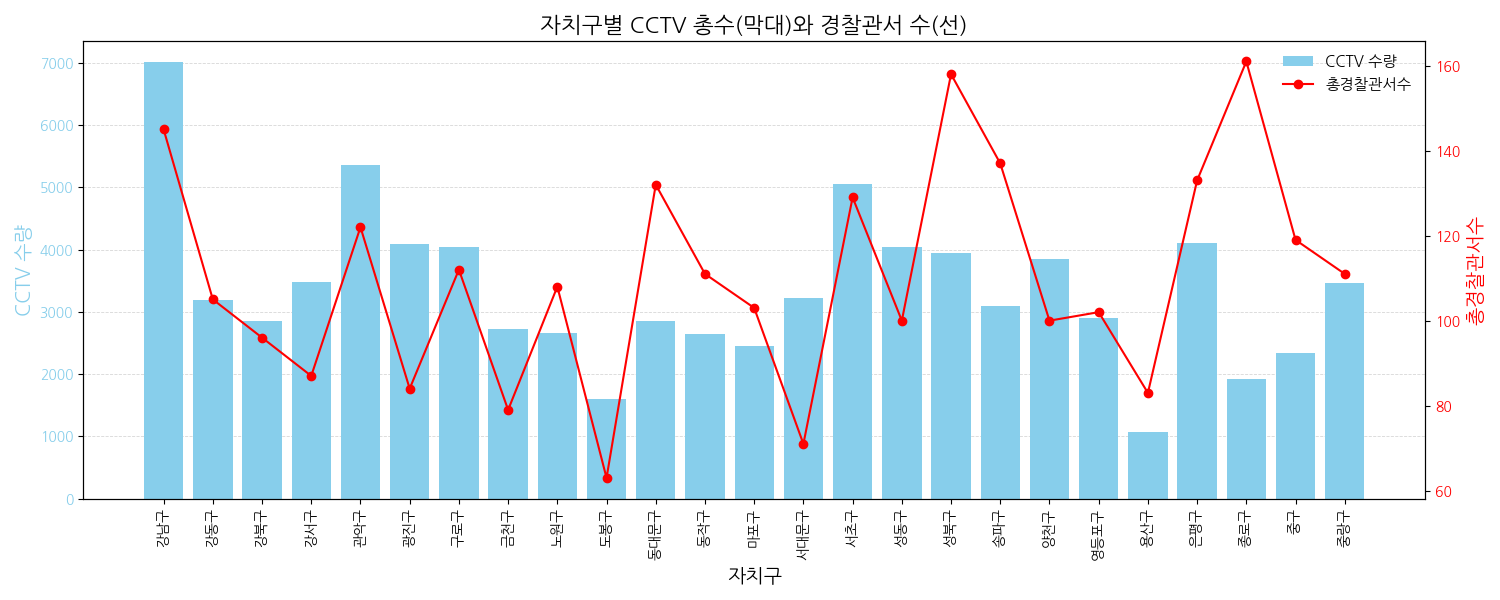

In [75]:
import numpy as np
import matplotlib.pyplot as plt

df_unique = df.drop_duplicates(subset="구별").copy()

labels = df_unique["구별"].tolist()
x = np.arange(len(labels))  # 0,1,2,... 위치

fig, ax1 = plt.subplots(figsize=(15,6))

# 막대: x 위치에 값
ax1.bar(x, df_unique["CCTV 수량"], color="skyblue", label="CCTV 수량")
ax1.set_xlabel("자치구")
ax1.set_ylabel("CCTV 수량", color="skyblue")
ax1.tick_params(axis="y", labelcolor="skyblue")
ax1.set_axisbelow(True)
ax1.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax1.xaxis.grid(False)

# ✔ x축 눈금/라벨 + 회전
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=90, ha="center")

# 이중축 선 그래프
ax2 = ax1.twinx()
ax2.plot(x, df_unique["총경찰관서수"], color="red", marker="o", label="총경찰관서수")
ax2.set_ylabel("총경찰관서수", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.yaxis.grid(False)

# ✔ 축 제목(fontsize) 키우기
ax1.set_xlabel("자치구", fontsize=14)
ax1.set_ylabel("CCTV 수량", fontsize=14)
ax2.set_ylabel("총경찰관서수", fontsize=14)

# ✔ x축 눈금 라벨 크기 + 회전
ax1.set_xticklabels(df_unique["구별"].tolist(), rotation=90, ha="center", fontsize=10)

# ✔ y축 눈금 라벨 크기
ax1.tick_params(axis="y", labelsize=10)
ax2.tick_params(axis="y", labelsize=10)

h1, l1 = ax1.get_legend_handles_labels()   # 왼쪽 축(막대) 범례
h2, l2 = ax2.get_legend_handles_labels()   # 오른쪽 축(선) 범례

ax1.legend(h1 + h2, l1 + l2,
           loc="upper right", fontsize=11, frameon=False)  # 위치/폰트/테두리 설정

# ✔ 제목 크기
plt.title("자치구별 CCTV 총수(막대)와 경찰관서 수(선)", fontsize=16)


fig.tight_layout()
plt.show()


CCTV 수량 기준 내림차순 정렬

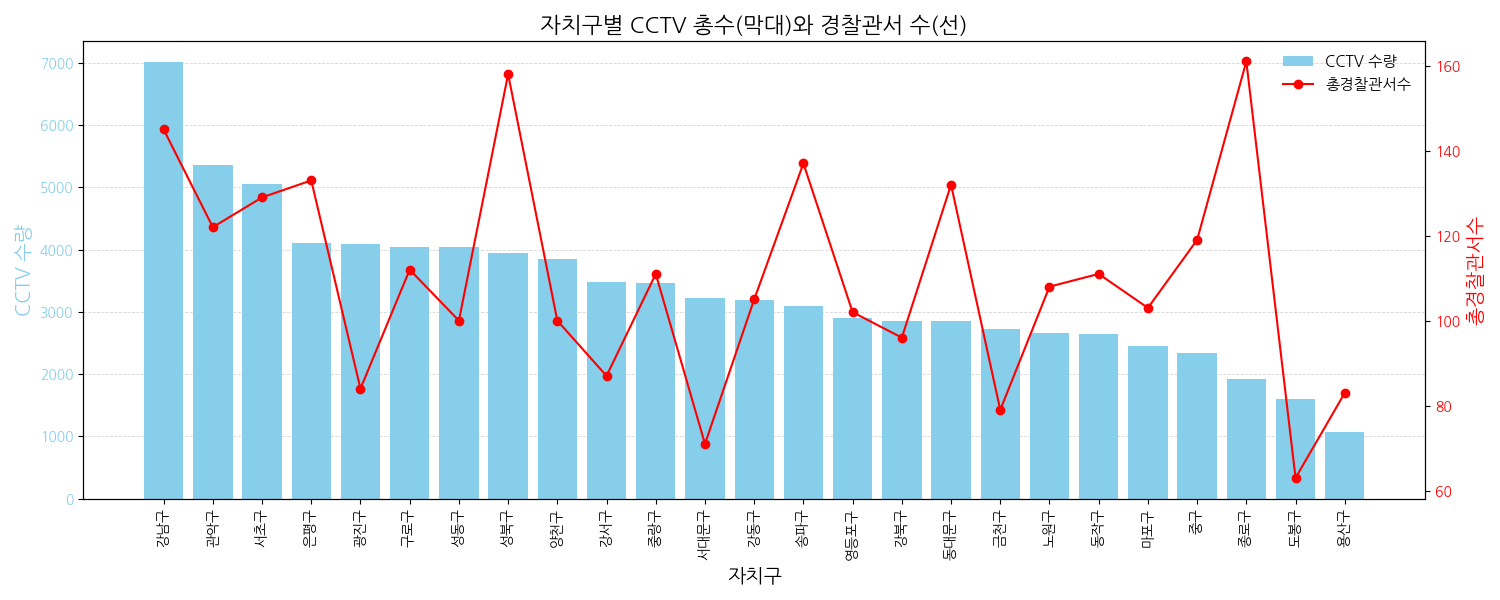

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# 자치구별 중복 제거 + CCTV 수량 기준 내림차순 정렬
df_unique = df.drop_duplicates(subset="구별").copy()
df_unique = df_unique.sort_values(by="CCTV 수량", ascending=False)

labels = df_unique["구별"].tolist()
x = np.arange(len(labels))

fig, ax1 = plt.subplots(figsize=(15,6))

# 막대: CCTV 수량
ax1.bar(x, df_unique["CCTV 수량"], color="skyblue", label="CCTV 수량")
ax1.set_xlabel("자치구", fontsize=14)
ax1.set_ylabel("CCTV 수량", color="skyblue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="skyblue", labelsize=10)
ax1.set_axisbelow(True)
ax1.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax1.xaxis.grid(False)

# x축 눈금 라벨 (정렬된 순서대로)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=90, ha="center", fontsize=10)

# 선 그래프 (경찰관서 수)
ax2 = ax1.twinx()
ax2.plot(x, df_unique["총경찰관서수"], color="red", marker="o", label="총경찰관서수")
ax2.set_ylabel("총경찰관서수", color="red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red", labelsize=10)
ax2.yaxis.grid(False)

h1, l1 = ax1.get_legend_handles_labels()   # 왼쪽 축(막대) 범례
h2, l2 = ax2.get_legend_handles_labels()   # 오른쪽 축(선) 범례

ax1.legend(h1 + h2, l1 + l2,
           loc="upper right", fontsize=11, frameon=False)  # 위치/폰트/테두리 설정

# 제목
plt.title("자치구별 CCTV 총수(막대)와 경찰관서 수(선)", fontsize=16)

fig.tight_layout()
plt.show()


- CCTV 수가 많은 지역(강남구, 관악구, 서초구)는 경찰관서 수도 많은 편이지만 반드시 비례하지는 않는다.
- 강남구, 관악구, 서초구는 CCTV가 많은 지역에 속한다.

경찰관서 수 기준 내림차순 정령

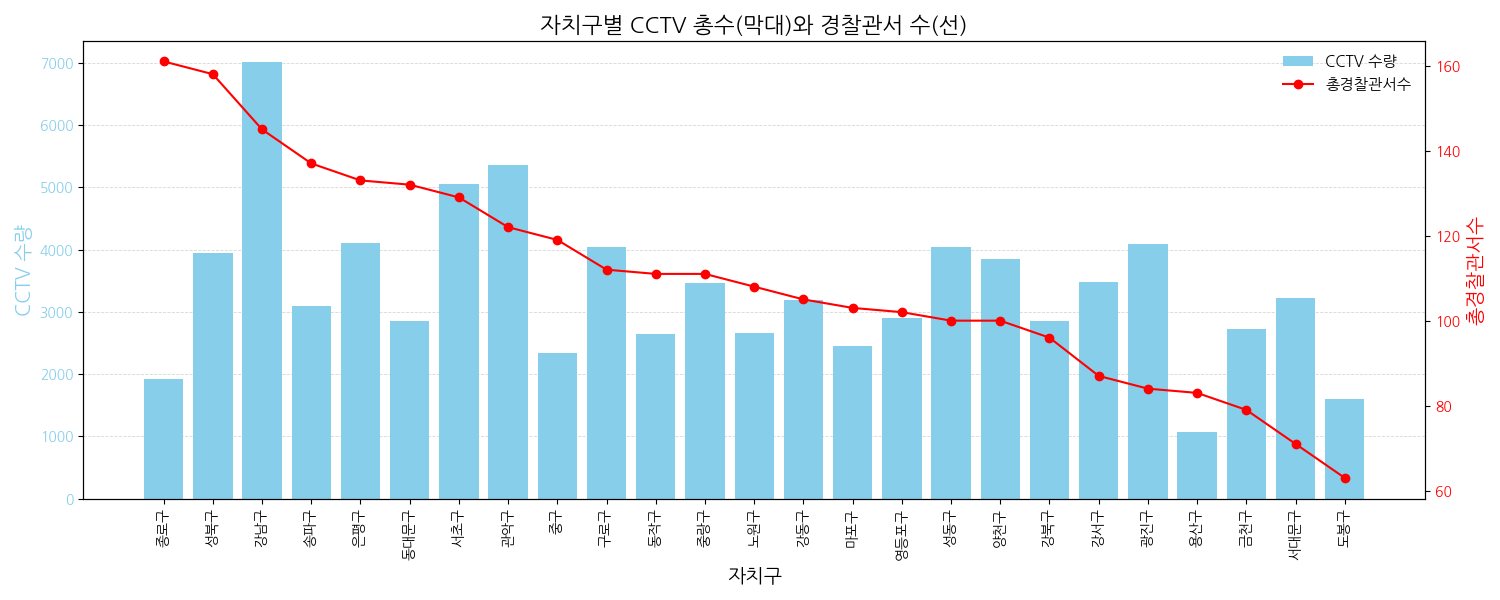

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# 자치구별 중복 제거 + 총경찰관서수 기준 내림차순 정렬
df_unique = df.drop_duplicates(subset="구별").copy()
df_unique = df_unique.sort_values(by="총경찰관서수", ascending=False)

labels = df_unique["구별"].tolist()
x = np.arange(len(labels))

fig, ax1 = plt.subplots(figsize=(15,6))

# 막대: CCTV 수량
ax1.bar(x, df_unique["CCTV 수량"], color="skyblue", label="CCTV 수량")
ax1.set_xlabel("자치구", fontsize=14)
ax1.set_ylabel("CCTV 수량", color="skyblue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="skyblue", labelsize=10)
ax1.set_axisbelow(True)
ax1.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax1.xaxis.grid(False)

# x축 눈금 라벨 (정렬된 순서대로)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=90, ha="center", fontsize=10)

# 선 그래프: 총경찰관서수
ax2 = ax1.twinx()
ax2.plot(x, df_unique["총경찰관서수"], color="red", marker="o", label="총경찰관서수")
ax2.set_ylabel("총경찰관서수", color="red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red", labelsize=10)
ax2.yaxis.grid(False)

h1, l1 = ax1.get_legend_handles_labels()   # 왼쪽 축(막대) 범례
h2, l2 = ax2.get_legend_handles_labels()   # 오른쪽 축(선) 범례

ax1.legend(h1 + h2, l1 + l2,
           loc="upper right", fontsize=11, frameon=False)  # 위치/폰트/테두리 설정
# 제목
plt.title("자치구별 CCTV 총수(막대)와 경찰관서 수(선)", fontsize=16)

fig.tight_layout()
plt.show()



- 종로구, 성북구, 강남구는 경찰관서 수가 많은 지역에 속한다.
- 상대적으로 도봉구, 용산구는 CCTV와 경찰관서 수가 둘 다 적은 지역이다.

툴팁

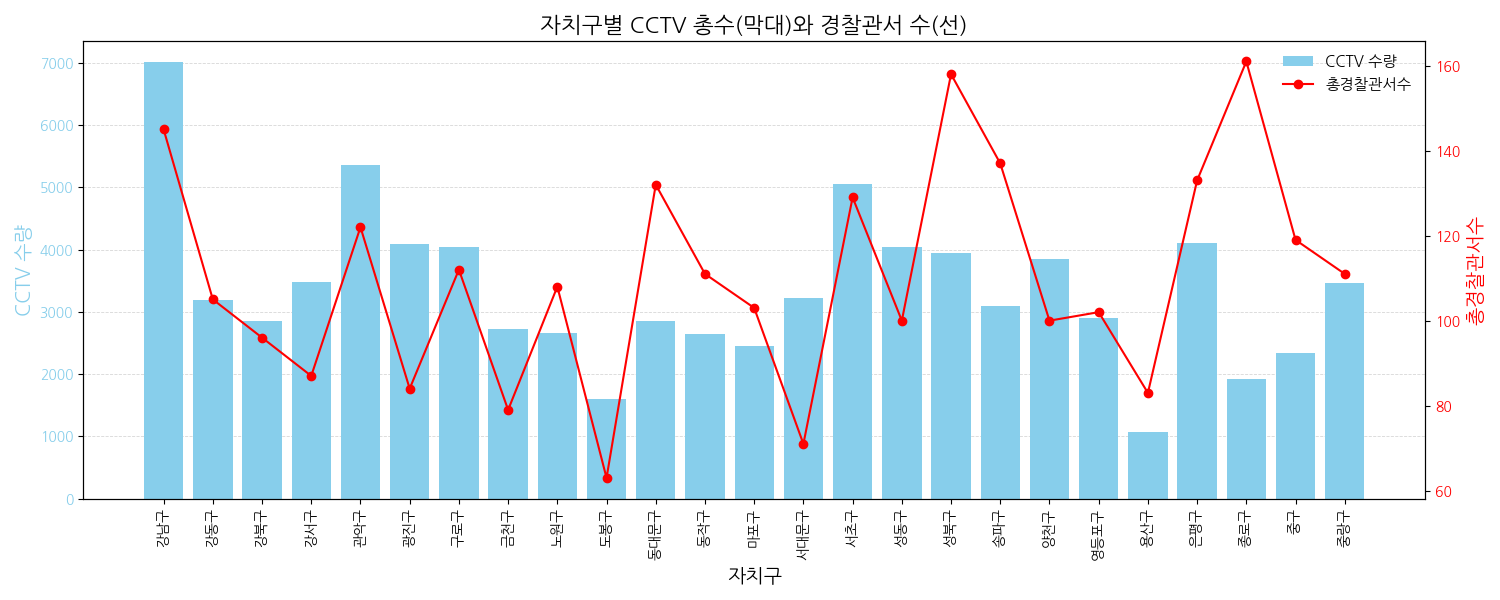

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# (선택) 주피터에서 완전한 인터랙션을 원하면 아래 중 하나 활성화하세요.
%matplotlib widget

df_unique = df.drop_duplicates(subset="구별").copy()

labels = df_unique["구별"].tolist()
x = np.arange(len(labels))  # 0,1,2,...

fig, ax1 = plt.subplots(figsize=(15,6))

# 막대: x 위치에 값  ✅ bars 핸들 저장(툴팁용)
bars = ax1.bar(x, df_unique["CCTV 수량"], color="skyblue", label="CCTV 수량")
ax1.set_xlabel("자치구", fontsize=14)
ax1.set_ylabel("CCTV 수량", color="skyblue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="skyblue", labelsize=10)
ax1.set_axisbelow(True)
ax1.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax1.xaxis.grid(False)

# x축 눈금/라벨 + 회전
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=90, ha="center", fontsize=10)

# 이중축 선 그래프  ✅ line 핸들 저장(툴팁용)
ax2 = ax1.twinx()
(line,) = ax2.plot(x, df_unique["총경찰관서수"], color="red", marker="o", label="총경찰관서수")
ax2.set_ylabel("총경찰관서수", color="red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red", labelsize=10)
ax2.yaxis.grid(False)

# 범례
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper right", fontsize=11, frameon=False)

plt.title("자치구별 CCTV 총수(막대)와 경찰관서 수(선)", fontsize=16)

# ==== 툴팁 추가 (mplcursors) ====
try:
    import mplcursors

    cursor = mplcursors.cursor([bars, line], hover=True)

    @cursor.connect("add")
    def on_add(sel):
        artist = sel.artist
        # 선(총경찰관서수)일 때: 가까운 x 인덱스 추정
        if artist is line:
            # 일부 백엔드에선 sel.target.index 가 없을 수 있어 보정
            idx = getattr(sel.target, "index", None)
            if idx is None:
                # x좌표에서 가장 가까운 인덱스 찾기
                idx = int(np.argmin(np.abs(x - sel.target[0])))
            val = int(df_unique["총경찰관서수"].iloc[idx])
            sel.annotation.set_text(f"{labels[idx]}\n총경찰관서수: {val:,}")
        else:
            # 막대(CCTV 수량)일 때
            idx = sel.index  # BarContainer에서 인덱스 제공
            val = int(df_unique["CCTV 수량"].iloc[idx])
            sel.annotation.set_text(f"{labels[idx]}\nCCTV 수량: {val:,}")
        # 툴팁 상자 스타일
        sel.annotation.get_bbox_patch().set(fc="white", ec="#888", alpha=0.95)

except ImportError:
    # mplcursors 미설치 시 안내(그래프는 그대로 표시)
    print("[알림] 툴팁을 사용하려면 'mplcursors'가 필요합니다. 예) uv pip install mplcursors")

fig.tight_layout()
plt.show()


### 2.2 인구수, CCTV 수량, 경찰관서수, 총 범죄발생수, 검거율 5개 변수 간의 상관관계 히트맵

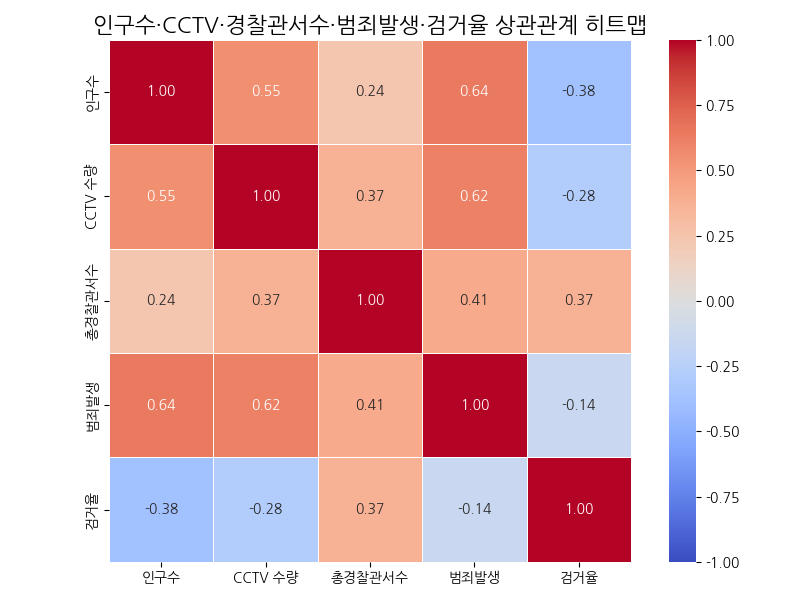

In [79]:
# 1) 분석에 쓸 컬럼 선택 (파일의 실제 컬럼명에 맞춰주세요)
cols = ["인구수", "CCTV 수량", "총경찰관서수", "범죄발생", "검거율"]  # "총 범죄발생수"가 있다면 "범죄발생" 대신 그 이름 사용

# 2) 자치구 중복 제거 후 숫자형만 사용
df_unique = df.drop_duplicates(subset="구별").copy()
num_df = df_unique[cols].apply(pd.to_numeric, errors="coerce")

# 3) 상관계수 계산 (피어슨)
corr = num_df.corr(method="pearson")

# 4) 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,        # 상자 안에 계수 값 표시
    fmt=".2f",         # 소수점 2자리
    cmap="coolwarm",   # 컬러맵
    vmin=-1, vmax=1,   # 상관계수 범위 고정
    square=True,       # 정사각형 격자
    linewidths=.5
)
plt.title("인구수·CCTV·경찰관서수·범죄발생·검거율 상관관계 히트맵", fontsize=16)  
plt.xticks(fontsize=10)  # x축 눈금
plt.yticks(fontsize=10)              # y축 눈금
plt.tight_layout()
plt.show()

- 범죄 발생 빈도와 범죄 발생은 0.64의 상관관계를 가진다. 범죄 기회가 인구 밀집 지역에서 많아진다는 시사점이 있다.
- 인구수와 CCTV 수량의 상관관계는 0.55로 행정적으로  인구 규모에 비례한 치안 장치 배치가 어느정도 이루어지고 있음을 알 수 있다.
- CCTV 수량과 범죄 발생의 상관관계는 0.62의 상관관계를 가진다. 이는 CCTV가 범죄를 유발하기보다는, 범죄가 자주 일어나는 곳에 CCTV 수량을 늘리는 대응적 설치의 결과로 해석할 수 있다.
- 인구수와 검거율을 -0.38의 상관관계를 가진다. 인구가 많을수록 사건이 많거나 특정인을 포착하기 어려움으로 인해 검거율이 상대적으로 낮아지는 효과 때문일 수 있다.


파생변수 생성(인구 10만명당 폭력 발생 건수)

In [81]:
# 자치구별 중복 제거
df_unique = df.drop_duplicates(subset="구별").copy()

# 새로운 파생변수: 인구 10만명당 폭력 발생 건수
df_unique["인구10만명당_폭력발생"] = df_unique["폭력_발생"] / df_unique["인구수"] * 100000

# 생성된 변수 확인
display(df_unique[["구별", "폭력_발생", "인구수", "인구10만명당_폭력발생"]].head())

,구별,폭력_발생,인구수,인구10만명당_폭력발생
0,강남구,3571,562526,634.815102
1,강동구,1569,502806,312.048782
2,강북구,1431,287523,497.699314
3,강서구,2195,558229,393.207805
4,관악구,2402,498000,482.329317


### 2.3 폭력 발생 건수가 가장 높은 상위 10개 구를 수평 막대그래프

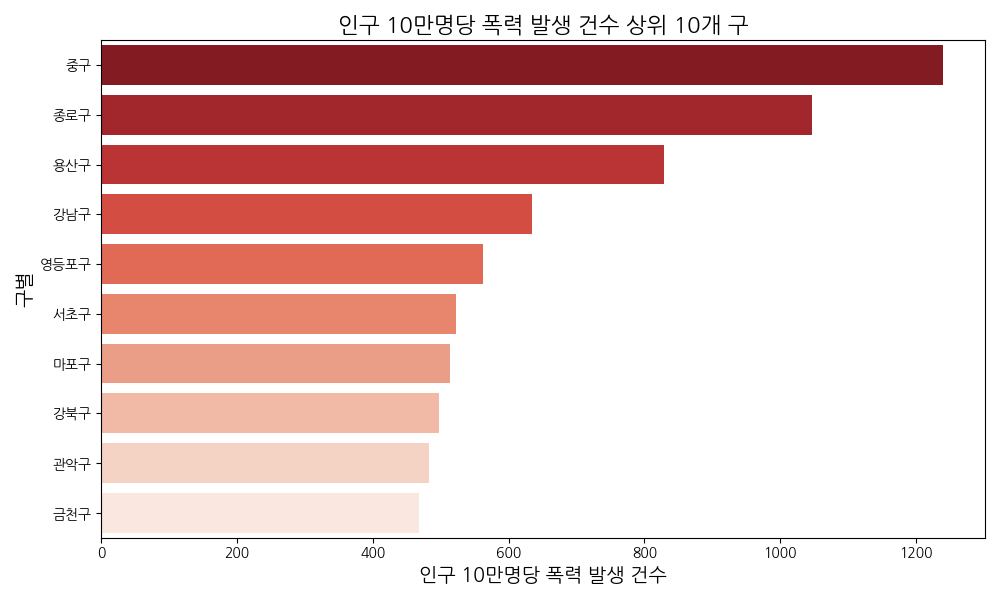

In [82]:
# 상위 10개 구 추출
top10 = df_unique.sort_values(by="인구10만명당_폭력발생", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10,
    y="구별",
    x="인구10만명당_폭력발생",
    hue='구별',
    legend=False,
    palette="Reds_r"
)

# 제목, 축 라벨 크기 조정
plt.title("인구 10만명당 폭력 발생 건수 상위 10개 구", fontsize=16)
plt.xlabel("인구 10만명당 폭력 발생 건수", fontsize=14)
plt.ylabel("구별", fontsize=14)

# 눈금 라벨 크기 조정
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


- 중구가 가장 높은 수치를 기록했고 종로구, 용산구도 상위권에 위치한다.

툴팁

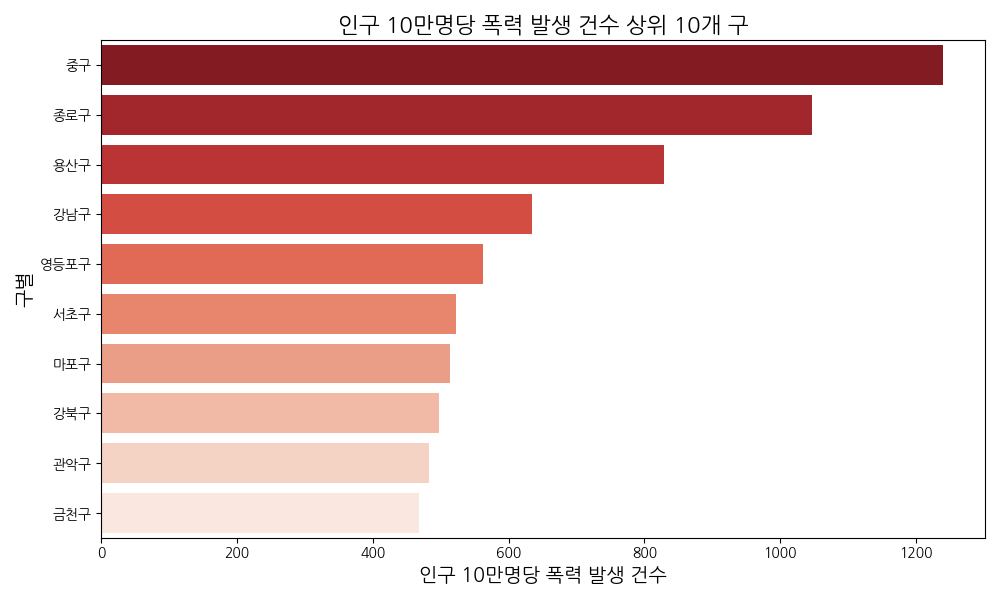

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 상위 10개 구 추출 (미리 정렬)
top10 = df_unique.sort_values(by="인구10만명당_폭력발생", ascending=False).head(10)
order = top10["구별"].tolist()  # 축 순서 고정

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=top10,
    y="구별",
    x="인구10만명당_폭력발생",
    hue="구별",
    order=order,         # ← 순서 고정(툴팁 매칭 안전)
    legend=False,
    palette="Reds_r"
)

# 제목, 축 라벨/눈금 폰트
plt.title("인구 10만명당 폭력 발생 건수 상위 10개 구", fontsize=16)
plt.xlabel("인구 10만명당 폭력 발생 건수", fontsize=14)
plt.ylabel("구별", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# ===== 툴팁 추가 (mplcursors) =====
try:
    import mplcursors
    import matplotlib.patches as mpatches

    # 현재 축의 막대(Rectangle)만 수집
    bars = [p for p in ax.patches if isinstance(p, mpatches.Rectangle) and p.get_width() > 0]
    # 막대 ↔ 인덱스 매핑 (그려진 순서 = order 순서)
    bar_to_idx = {id(b): i for i, b in enumerate(bars)}
    values = top10["인구10만명당_폭력발생"].to_numpy()

    cursor = mplcursors.cursor(bars, hover=True)

    @cursor.connect("add")
    def _on_add(sel):
        b = sel.artist
        i = bar_to_idx.get(id(b), 0)
        gu = order[i]
        val = values[i]
        sel.annotation.set_text(f"{gu}\n인구10만명당 폭력: {val:,.2f}")
        sel.annotation.get_bbox_patch().set(fc="white", ec="#888", alpha=0.95)

except ImportError:
    print("[알림] 툴팁을 사용하려면 'mplcursors'가 필요합니다. 예) uv pip install mplcursors")

plt.show()


## 3. 종합 결론

### 3.1 경찰관서 수와 안전의 관계
- 경찰 조직 수와 범죄 발생
    - 상관계수: +0.41
    - 경찰관서가 많은 구일수록 범죄 발생 건수도 많은 경향이 있다. 범죄 발생이 많으니 그에 맞춰 경찰관서를 더 설치한 반영적 배치 성격이 강하다.
- 경찰 조직 수와 검거율
    - 상관계수: +0.37
    - 경찰관서 수가 많을수록 검거율이 높아지는 경향이 있다. 경찰관서 수가 많을수록 사건 대응 인력이 분산 배치되어 범죄 수사와 검거에 긍정적 효과를 준다고 해석할 수 있다.
- 종합분석
    - 경찰 조직 수가 범죄 발생 억제에 주는 영향은 제한적이지만, 경찰 조직 수가 많을수록 검거율이 높아지는 경향이 있으므로 범죄 해결 및 검거율 향상에 기여합니다.


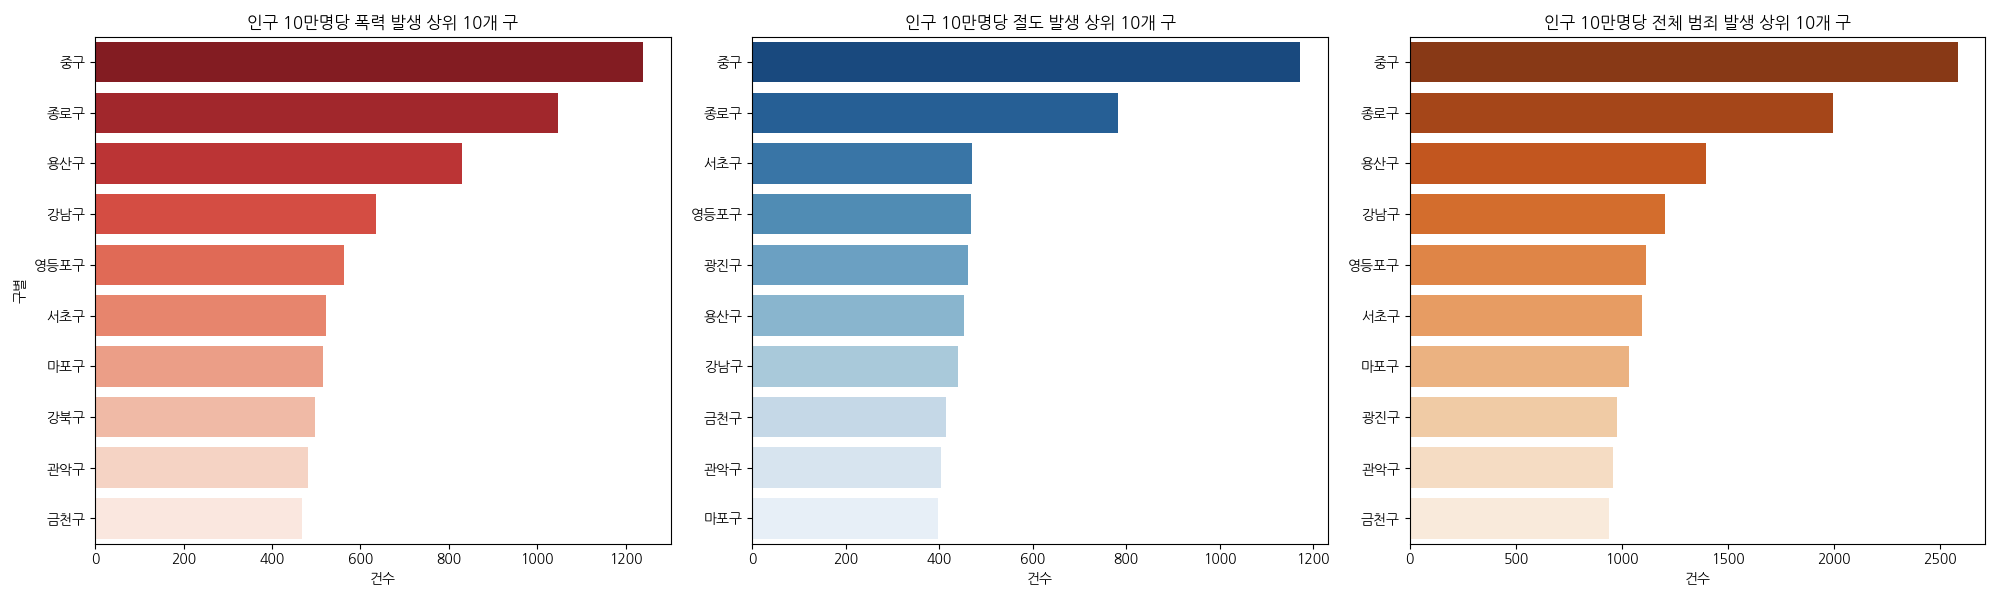

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 0) 자치구별 중복 제거
df_unique = df.drop_duplicates(subset="구별").copy()

# 1) 파생 변수 생성 (인구 10만 명당)
df_unique["인구10만명당_폭력발생"] = df_unique["폭력_발생"] / df_unique["인구수"] * 100000
df_unique["인구10만명당_절도발생"] = df_unique["절도_발생"] / df_unique["인구수"] * 100000
df_unique["인구10만명당_범죄발생"] = df_unique["범죄발생"] / df_unique["인구수"] * 100000  # 전체 범죄

# 2) 상위 10개 구 추출 함수
def top10_by(col):
    return df_unique.sort_values(by=col, ascending=False).head(10)

top_violence = top10_by("인구10만명당_폭력발생")
top_theft    = top10_by("인구10만명당_절도발생")
top_total    = top10_by("인구10만명당_범죄발생")

# 3) Subplots (1x3)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

# (a) 폭력
sns.barplot(data=top_violence, y="구별", x="인구10만명당_폭력발생",  hue='구별',legend=False,palette="Reds_r", ax=axes[0])
axes[0].set_title("인구 10만명당 폭력 발생 상위 10개 구")
axes[0].set_xlabel("건수")
axes[0].set_ylabel("구별")

# (b) 절도
sns.barplot(data=top_theft, y="구별", x="인구10만명당_절도발생",  hue='구별',legend=False,palette="Blues_r", ax=axes[1])
axes[1].set_title("인구 10만명당 절도 발생 상위 10개 구")
axes[1].set_xlabel("건수")
axes[1].set_ylabel("")

# (c) 전체 범죄
sns.barplot(data=top_total, y="구별", x="인구10만명당_범죄발생",  hue='구별',legend=False,palette="Oranges_r", ax=axes[2])
axes[2].set_title("인구 10만명당 전체 범죄 발생 상위 10개 구")
axes[2].set_xlabel("건수")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()


### 3.2 범죄 유형별 분석

- 범죄 유형
   - 폭력 : 중구, 종로구, 용산구가 가장 높은 폭력 발생률을 보인다.
   - 절도 : 중구, 종로구가 가장 높은 절도 발생률을 보인다.
   - 전체 범죄 발생 : 중구, 종로구가 높구 용상구, 강남구가 그 뒤를 잇는다.

- 종합해석
   - 중구와 종로구는 폭력, 절도, 전체 범죄 모두 상위권에 해당하므로 범죄율이 전반적으로 높은 지역이다.
   - 용산구와 강남구는 폭력 범죄에서는 상위권이지만 절도에서는 상대적으로 낮다.
   - 서초구, 광진구는 폭력 범죄에 비해 절도에서 높은 범죄율 가진다.
